In [1]:
using Gen
using Random
using CairoMakie
using Distributions

#### Helper functions

In [2]:
const Card = Union{Symbol, Int}
const State = Tuple{Int, Card, Bool}

CARD_MAP = [:ace, :two, :three, :four, :five, :six, :seven, :eight, :nine, :ten, :jack, :queen, :king]

function sort_hand(hand)
    # aces should be last
    return sort(hand, lt=(x,y) -> x != :ace)
end

function get_value(card, sum_so_far)
    if card == :ace
        if sum_so_far + 11 <= 21
            return 11
        else
            return 1
        end
    elseif card == :jack || card == :queen || card == :king
        return 10
    else
        # get index in card map
        return findfirst(x -> x == card, CARD_MAP)
    end
end

function get_sum(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        sum += get_value(card, sum)
    end
    return sum
end

function holds_usable_ace(hand)
    hand = sort_hand(hand)
    sum = 0
    for card in hand
        value = get_value(card, sum)    
        if value == 11
            return true
        end
        sum += value
    end
    return false
end

function states()
    states = []
    for i in 4:21
        for j in 1:13
            for k in [true, false]
                push!(states, (i, CARD_MAP[j], k))
            end
        end
    end
    return states
end

STATES = states();

using CairoMakie
using IJulia  # For clearing output in Jupyter notebooks

function plot_policy()
    
    # Define ranges for player sums and dealer showing cards
    player_sums = 12:21  # x-axis
    dealer_showing = 1:13  # y-axis

    # Create observable variables for z-values (initially zero)
    z_true = Observable(zeros(Float64, length(player_sums), length(dealer_showing)))
    z_false = Observable(zeros(Float64, length(player_sums), length(dealer_showing)))

    # Create figure
    fig = Figure(resolution = (800, 600))

    # Surface plot with usable ace
    ax1 = Axis3(fig[1, 1], title = "Usable Ace")
    surface!(ax1, player_sums, dealer_showing, z_true)
    ax1.xlabel = "Player sum"
    ax1.ylabel = "Dealer showing"
    ax1.zlabel = "1 = Hit, 0 = Stick"

    # Surface plot without usable ace
    ax2 = Axis3(fig[1, 2], title = "No Usable Ace")
    surface!(ax2, player_sums, dealer_showing, z_false)
    ax2.xlabel = "Player sum"
    ax2.ylabel = "Dealer showing"
    ax2.zlabel = "1 = Hit, 0 = Stick"

    # Function to update the observables with new trace data
    function update_plot(policy::Dict{State, Float64})
        

        new_z_true = zeros(Float64, length(player_sums), length(dealer_showing))
        new_z_false = zeros(Float64, length(player_sums), length(dealer_showing))

        for i in player_sums
            for j in dealer_showing
                card = CARD_MAP[j]
                new_z_true[i - 11, j] = policy[(i, card, true)]
                new_z_false[i - 11, j] = policy[(i, card, false)]
            end
        end

        # Update the observables with new values
        z_true[] = new_z_true
        z_false[] = new_z_false

        # Clear the old output in the notebook and display the new plot
        IJulia.clear_output(true)  # Clear the old output in the current cell
        display(fig)  # Display the updated figure
    end

    # Display the figure for the first time
    display(fig)

    return update_plot  # Return the function that updates the plot
end;


#### Helper distributions

In [3]:
@dist function draw_card()
    card = uniform_discrete(1,13)
    CARD_MAP[card]
end;


#### Model

In [14]:
@gen function blackjack_model(policy::Dict{State, Float64}, eps)
    sum = 0

    # Player
    card1 = draw_card()
    card2 = draw_card()
    hand = [card1, card2]

    # Dealer
    dealer_first_card = draw_card()
    dealer_visible_card = draw_card()

    sum = get_sum(hand)
    states = []
    push!(states, (sum, dealer_visible_card, holds_usable_ace(hand)))

    # Player's turn
    for i in 1:9 
        action = {(:action, i)} ~ bernoulli(policy[states[i]])

        if action
            card = draw_card()
            push!(hand, card)
            sum = get_sum(hand)
            push!(states, (sum, dealer_visible_card, holds_usable_ace(hand)))
            if sum > 21
                break
            end
        else
            break
        end
    end

    # Dealer's turn
    dealer_hand = [dealer_first_card, dealer_visible_card]
    dealer_sum = get_sum(dealer_hand)
    while dealer_sum < 17
        card = draw_card()
        push!(dealer_hand, card)
        dealer_sum = get_sum(dealer_hand)
    end

    ret = 0
    
    # Determine winner
    if sum > 21
        ret = {:return} ~ normal(-1, eps)
    elseif dealer_sum > 21
        ret = {:return} ~ normal(1, eps)
    elseif sum > dealer_sum
        ret = {:return} ~ normal(1, eps)
    elseif sum < dealer_sum
        ret = {:return} ~ normal(-1, eps)
    else
        ret = {:return} ~ normal(0, eps)
    end


    return states, hand, dealer_sum, ret
end;

In [15]:
policy = Dict{State, Float64}()
for state in STATES
    if state[1] < 20
        policy[state] = 1
    else 
        policy[state] = 0
    end
end


trace = simulate(blackjack_model, (policy, 0.01))
visited_states, hand, dealer_sum, ret = get_retval(trace)
println(visited_states)

Any[(12, :six, true), (18, :six, true), (16, :six, false), (22, :six, false)]


#### Monte Carlo Prediction: Estimate state value

In [6]:
# first visit MC Prediction
# input = policy to be evaluated
# initialize: 
    # V(s) in R, arbitrarily, for all s in S
    # Return(s) <-- an empty list, for all s in S

v::Dict{State, Float64} = Dict()
returns:: Dict{State, Array{Float64}} = Dict()

for state in STATES
    v[state] = 0
    returns[state] = []
end

for i in 1:1e6
    trace = simulate(blackjack_model, (policy,0.01))
    visited_states, hand, dealer_sum, ret = get_retval(trace)
    for (j, state) in enumerate(visited_states)
        if state in visited_states
            # first visit MC
            if findfirst(s -> s == state, visited_states) == j && state[1] < 22
                push!(returns[state], ret)
                v[state] = mean(returns[state])
            end
        end
    end
end

v

Dict{Tuple{Int64, Union{Int64, Symbol}, Bool}, Float64} with 468 entries:
  (20, :queen, 1) => 0.426823
  (8, :ten, 0)    => -0.565923
  (9, :three, 1)  => 0.0
  (20, :king, 0)  => 0.438497
  (19, :five, 1)  => -0.436005
  (21, :ace, 0)   => 0.636841
  (11, :nine, 0)  => -0.0179332
  (11, :two, 1)   => 0.0
  (15, :three, 0) => -0.637595
  (17, :eight, 0) => -0.674114
  (12, :four, 0)  => -0.542405
  (9, :queen, 1)  => 0.0
  (14, :ten, 0)   => -0.639334
  (9, :king, 0)   => -0.57129
  (10, :nine, 0)  => -0.0969034
  (6, :three, 0)  => -0.504965
  (10, :two, 1)   => 0.0
  (5, :jack, 0)   => -0.557756
  (12, :six, 0)   => -0.529114
  (15, :eight, 0) => -0.619534
  (8, :three, 1)  => 0.0
  (20, :nine, 0)  => 0.759842
  (20, :two, 1)   => 0.623384
  (12, :six, 1)   => -0.439636
  (5, :nine, 1)   => 0.0
  ⋮               => ⋮

#### Monte Carlo Estimation of Action Values = Policy evaluation

In [17]:
# first visit MC Estimation of Action Values
# input = policy to be evaluated
# initialize: 
    # q(s, a) in R, arbitrarily, for all s in S
    # Return(s, a) <-- an empty list, for all s in S

    for state in STATES
        policy[state] = 0.5
    end

    q::Dict{Tuple{State, Bool}, Float64} = Dict()
    q_returns:: Dict{Tuple{State, Bool}, Array{Float64}} = Dict()

    
    for state in STATES
        policy[state] = 0.5
        for action in [false, true]
            q[(state, action)] = 0
            q_returns[(state, action)] = []
        end
    end
    
    for i in 1:10000000
        trace = simulate(blackjack_model, (policy,0.01))
        visited_states, hand, dealer_sum, ret = get_retval(trace)
        for (j, state) in enumerate(visited_states)
            if state in visited_states
                if findfirst(s -> s == state, visited_states) == j && state[1] < 22
                    push!(q_returns[(state, trace[(:action, j)])], ret)
                    q[(state, trace[(:action, j)])] = mean(q_returns[(state, trace[(:action, j)])])
                end
            end
        end
    end
    
    q

Dict{Tuple{Tuple{Int64, Union{Int64, Symbol}, Bool}, Bool}, Float64} with 936 entries:
  ((5, :ten, 0), 1)    => -0.608603
  ((7, :queen, 1), 0)  => 0.0
  ((19, :seven, 1), 1) => -0.259905
  ((12, :eight, 1), 1) => -0.450398
  ((13, :three, 0), 0) => -0.245876
  ((17, :seven, 1), 0) => -0.112607
  ((19, :queen, 1), 0) => -0.0182005
  ((7, :two, 1), 0)    => 0.0
  ((17, :nine, 1), 1)  => -0.411115
  ((8, :seven, 0), 0)  => -0.473384
  ((18, :five, 0), 1)  => -0.792949
  ((21, :jack, 1), 1)  => -0.434206
  ((14, :six, 1), 0)   => -0.153207
  ((5, :ten, 1), 1)    => 0.0
  ((16, :four, 1), 0)  => -0.226228
  ((8, :two, 0), 0)    => -0.298502
  ((18, :jack, 0), 1)  => -0.824472
  ((7, :ten, 0), 1)    => -0.587361
  ((19, :two, 1), 0)   => 0.383267
  ((10, :king, 1), 0)  => 0.0
  ((16, :eight, 0), 1) => -0.697756
  ((5, :ten, 1), 0)    => 0.0
  ((12, :eight, 0), 0) => -0.508508
  ((18, :six, 0), 1)   => -0.798737
  ((20, :ace, 0), 0)   => 0.161975
  ⋮                    => ⋮

#### Monte Carlo Control to approximate optimal policies

The following algorithm calculates the bernoulli parameter for the optimal action. 0 = stick, 1 = hit.

In [8]:
# Monte Carlo with Exploring Starts

new_policy:: Dict{State, Float64} = Dict()
for state in STATES
    policy[state] = 0.5
    new_policy[state] = NaN
    for action in [false, true]
        q_returns[(state, action)] = []
    end
end


for i in 1:1000000
    trace = simulate(blackjack_model, (policy,))
    visited_states, hand, dealer_sum, ret = get_retval(trace)
    for (j, state) in enumerate(visited_states)
        if state in visited_states
            # all visits and not only first, because in blackjack especially the last one is important
            if state[1] < 22 # && findfirst(s -> s == state, visited_states) == j 
                push!(q_returns[(state, trace[(:action, j)])], ret)
                hit_success_rate = count(x -> x > -1, q_returns[(state, true)]) / length(q_returns[(state, true)])
                stick_success_rate = count(x -> x > -1, q_returns[(state, false)]) / length(q_returns[(state, false)])
                # calculate the ratio between hit success and stick success to obtain p for the bernoulli distribution of the policy.
                new_policy[state] = ((hit_success_rate * 2 + stick_success_rate * 1) / (hit_success_rate + stick_success_rate)) - 1
            end
        end
    end
end



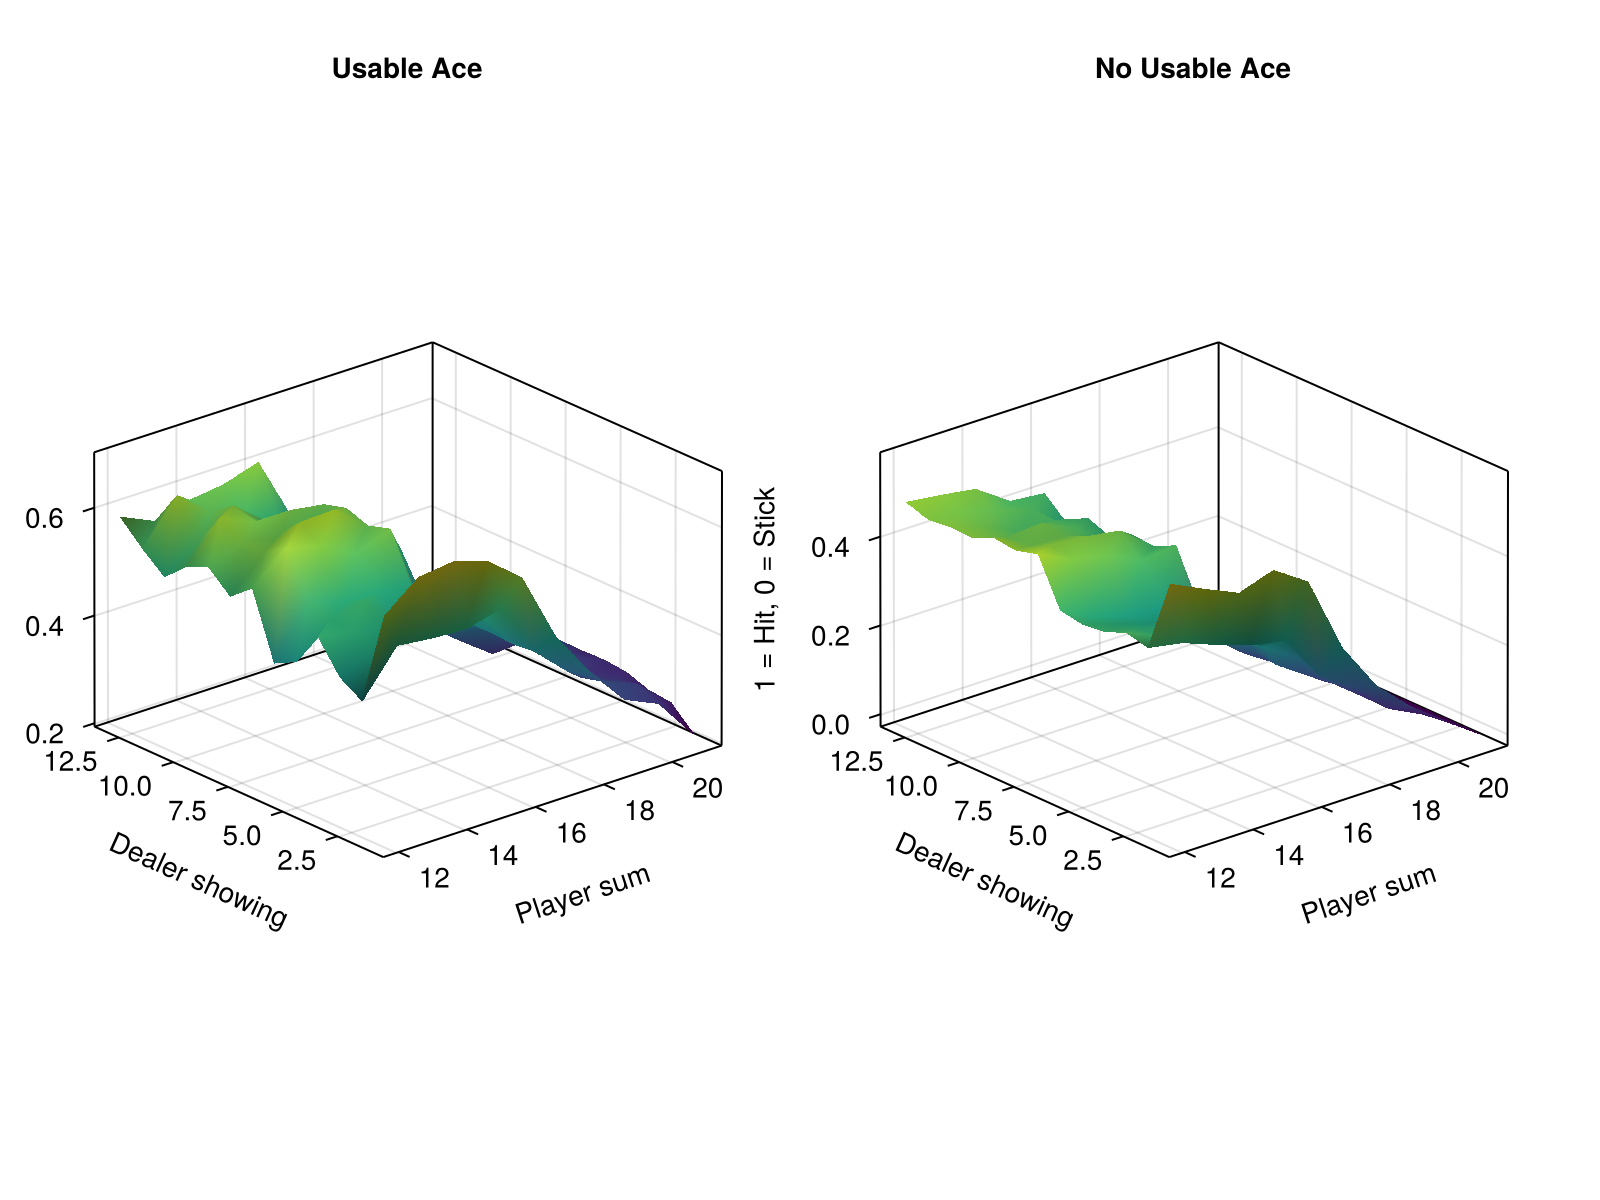

CairoMakie.Screen{IMAGE}


In [9]:
update_plot = plot_policy()
update_plot(new_policy)